<a href="https://colab.research.google.com/github/christian-byrne/tucson-crime-models/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Define common types used in code

In [344]:
from typing import Union, Dict, Any, Tuple, Dict, List, Optional

BoundingBox = Tuple[float, float, float, float]

# Utils

## Configuration & Constants

In [345]:
from pathlib import Path


class Config:
    # Embedded configuration data
    _config_data: Dict[str, Any] = {
        # hyperparameters
        "hp": {
            # the ratio of the dataset to use for testing
            "test_size" : 0.2,
            "subsection_count": 32,  # Number of subsections to divide the city into
            # the number of cross-validation folds to use for each model
            "cross_val_folds": {
                "linear": 5,
                "best_subset": 5,
                "lasso": 5,
                "ridge": 5,
            },
            # the scoring metric to use for each model during cross-validation
            "scoring_metric": {
                "best_subset": "r2",
                "lasso": "r2",
                "ridge": "r2",
            },
            # the sparse infrastructure types to calculate distance-to for
            "distance_to_nearest_infrastructure": [
                "fire_stations",
                "landfills",
                "streetcar_stops",
                "streetcar_routes",
            ],
            "count_instances_infrastructure": [
                "bicycle_boulevards",
                "bridges",
                "crosswalks",
                # "business_licenses", # NOTE: business licenses don't have geometry data
                "major_streets",
                # "scenic_routes", # NOTE Reason for exclusion: very low correlation of -0.16
                "sidewalks",
                "streetlights",
                "suntran_stops",
            ],
            # the method to use to determine whether an infrastructure type is considered "nearby"
            # Use `geometry.within` to check if the object is fully contained within the subsection
            # Use `geometry.intersects` to check if geometries share any part of their space
            # Use `geometry.overlaps` to check if geometries overlap, but it excludes cases where one geometry entirely contains or is entirely contained by the other
            "geometry_contains_method": {
                "arrests": "within",
                "bicycle_boulevards": "intersects",
                "bridges": "within",
                # "business_licenses": "within", # NOTE: business licenses don't have geometry data
                "crosswalks": "intersects",
                "fire_stations": "within",
                "landfills": "within",
                "major_streets": "intersects",
                "streetcar_routes": "intersects",
                "streetcar_stops": "within",
                "scenic_routes": "intersects",
                "sidewalks": "intersects",
                "streetlights": "within",
                "suntran_stops": "within",
            },
        },
        # model config
        "feature_names" : {
            "model1" : [
                "bicycle_boulevards",
                "bridges",
                "crosswalks",
                "fire_stations",
                "landfills",
                "major_streets",
                "streetcar_routes",
                "streetcar_stops",
                "scenic_routes",
                "sidewalks",
                "streetlights",
                "suntran_stops",
            ],
        },
        # dev config
        "log_level": "WARNING",
        # data config
        "tucson_center_coordinates": [32.22174, -110.92648],
        "tucson_bounds": [-111, 31.042601, -110.7347, 32.2226],
        "data_sources": {
            "arrests": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/crime/Tucson_Police_Arrests_-_2017_-_Open_Data.geojson",
            "bicycle_boulevards": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Bicycle_Boulevards.geojson",
            "bridges": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Bridges_-_Open_Data.geojson",
            "business_licenses": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Business_Licenses_(Open_Data).geojson",
            "crosswalks": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Crosswalks_-_Open_Data.geojson",
            "fire_stations": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Fire_Stations.geojson",
            "landfills": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Landfills_(Eastern_Pima_County).geojson",
            "major_streets": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Major_Streets_and_Routes_-_Open_Data.geojson",
            "streetcar_routes": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Modern_Streetcar_Route_(Polygon)_-_Open_Data.geojson",
            "streetcar_stops": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Modern_Streetcar_Stops_-_Open_Data.geojson",
            "scenic_routes": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Scenic_Routes_-_Open_Data.geojson",
            "sidewalks": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Sidewalks.geojson",
            "streetlights": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Streetlights_-_City_of_Tucson_-_Open_Data.geojson",
            "suntran_stops": "https://raw.githubusercontent.com/christian-byrne/tucson-crime-models/main/data/infrastructure/Sun_Tran_Bus_Stops_-_Open_Data.geojson",
        },
    }

    def __getitem__(self, key: str) -> Any:
        """Get a configuration value by key, with KeyError if missing."""
        if key not in Config._config_data:
            msg = (
                f"Could not find key '{key}' in config."
                + f"Available keys: {list(Config._config_data.keys())}"
            )
            raise KeyError(msg)
        return Config._config_data[key]

    def __setitem__(self, key: str, value: Union[str, Path]) -> None:
        """Set a configuration value by key, converting Path to string if necessary."""
        if isinstance(value, Path):
            value = str(value.resolve())
        Config._config_data[key] = value

    @classmethod
    def get_all(cls) -> Dict[str, Any]:
        """Return the entire configuration data dictionary."""
        return cls._config_data


config = Config()

## Logging Utils

In [346]:
import logging
from rich.logging import RichHandler


class Logger:
    def __init__(self, logger_name: str, level: int = logging.INFO):
        self.logger_base = logging.getLogger(logger_name)

        # Ensure no handlers are duplicated and set propagate to False
        self.logger_base.handlers.clear()
        self.logger_base.propagate = False

        rich_handler = RichHandler(
            rich_tracebacks=True, tracebacks_show_locals=True, markup=True
        )

        formatter = logging.Formatter("%(message)s")
        rich_handler.setFormatter(formatter)

        self.logger_base.addHandler(rich_handler)
        self.logger_base.setLevel(level)

    def __call__(self):
        return self.logger_base


logger = Logger("General", config["log_level"])()

# Model 1—Subsection-Level Crime Frequency Prediction Using Infrastructure and Socioeconomic Features

## 1—Data Collection

### 1.1—Fetch and Load Datasets from Repo

In [347]:
import geopandas as gpd
import requests
from typing import Dict

# Dictionary to cache datasets in memory to prevent re-fetching in same session
_cache: Dict[str, gpd.GeoDataFrame] = {}


def load_dataset(dataset_name: str):
    # Check if the dataset is already cached
    if dataset_name in _cache:
        logger.info(f"Using cached data for {dataset_name}")
        return _cache[dataset_name]

    # Load the dataset from Config if not cached
    filepath = config["data_sources"][dataset_name]

    if filepath.startswith("http"):
        logger.info(f"Downloading dataset from {filepath}")
        response = requests.get(filepath)
        response.raise_for_status()
        with open(f"/tmp/{dataset_name}.geojson", "wb") as f:
            f.write(response.content)
        dataframe = gpd.read_file(f"/tmp/{dataset_name}.geojson")
    else:
        dataframe = gpd.read_file(filepath)

    logger.info(f"Loaded data from {filepath}")
    logger.debug(
        f"Columns in {filepath.split('/')[-1]}:\n{', '.join(dataframe.columns)}"
    )

    # Cache the loaded dataset
    _cache[dataset_name] = dataframe

    return dataframe

## 2—Data Processing and Cleaning

### 2.1—Remove NaN and Null

In [348]:
arrests_data = load_dataset("arrests")

# TODO: fix these
# remove null values from the dataset
# arrests_data = arrests_data.dropna()

# remove any rows with missing location data
# arrests_data = arrests_data.dropna(subset=["geometry"])

### 2.2—Determine Bounds of Area of Interest

In [349]:
def get_geometry_extremes(data: gpd.GeoDataFrame) -> BoundingBox:
    """Get the minimum and maximum latitude and longitude values from the dataset."""
    min_x_2, min_y_2, max_x_2, max_y_2 = data.total_bounds
    return min_x_2, min_y_2, max_x_2, max_y_2

DATASET_TO_USE_FOR_REGION = "sidewalks"
min_x, min_y, max_x, max_y = get_geometry_extremes(
    load_dataset(DATASET_TO_USE_FOR_REGION)
)

# Set tucson city bounds in config to the extremes of the arrests (target variable) dataset
print(f"Chaning tucons bounds from\n{config['tucson_bounds']} to\n{min_x, min_y, max_x, max_y}")
config["tucson_bounds"] = [min_x, min_y, max_x, max_y]

Chaning tucons bounds from
[-111, 31.042601, -110.7347, 32.2226] to
(np.float64(-111.05254574930352), np.float64(32.06233602492571), np.float64(-110.72263755643428), np.float64(32.32006865632446))


### 2.1—Filter GIS Data by Bounds

In [350]:
import geopandas as gpd
from shapely.geometry import box


def filter_by_bounds(data: gpd.GeoDataFrame, bounds: BoundingBox) -> gpd.GeoDataFrame:
    """
    Filters the GeoDataFrame to include only points within the specified bounds.

    Parameters:
    data (GeoDataFrame): The data to filter.
    bounds (tuple): A tuple (minx, miny, maxx, maxy) defining the bounding box.

    Returns:
    GeoDataFrame: Filtered GeoDataFrame with points within the bounds.
    """
    logger.debug(f"Filtering data by bounds: {bounds}")
    bbox = box(*bounds)

    if len(data) == 0:
        logger.error("No data found in the input GeoDataFrame. Check the input data.")
        return data

    # Filter data by checking if geometry is within the bounding box
    filtered = data[data.geometry.within(bbox)]
    logger.info(
        f"Filtered out {len(data) - len(filtered)} rows outside the bounds. {len(filtered)} rows remaining."
    )

    if len(data) == len(filtered):
        logger.warning("All data is within the specified bounds. No data was filtered.")

    if len(filtered) == 0:
        logger.error(
            f"All data was filtered out. Check that the bounds {bounds} are correct."
        )

    return filtered

### 2.2—Construct/Partition Subsections

Create a function to divide the area of interest into subsections using a simple grid approach.

In [351]:
def create_subsections(number: int, domain: BoundingBox) -> List[BoundingBox]:
    """
    Partition a bounding box into a grid of subsections. Create a pandas DataFrame that (for now) contains just
    an empty row for each subsection.

    Params:
    number: int - number of subsections
    bbox: tuple[Float] - (min_x, min_y, max_x, max_y) - bounding box of the area to be divided
    """
    min_x, min_y, max_x, max_y = domain

    # Convert to float to prevent truncation
    x_diff = (max_x - min_x) / float(number)
    y_diff = (max_y - min_y) / float(number)

    subsections = []
    for i in range(number):
        for j in range(number):
            subsections.append(
                (
                    min_x + i * x_diff,
                    min_y + j * y_diff,
                    min_x + (i + 1) * x_diff,
                    min_y + (j + 1) * y_diff,
                )
            )

    return subsections

Create a separete function which creates rectangular subsections of semi-random size.

In [352]:
import random


def create_random_subsections(
    domain: BoundingBox, target_num: int
) -> List[BoundingBox]:
    """
    Partition a bounding box into a grid of subsections, aiming for a target number of subsections.
    Sizes are adjusted dynamically based on the target number and remaining space.

    Params:
    domain: BoundingBox - (min_x, min_y, max_x, max_y) - bounding box of the area to be divided.
    target_num: int - Target number of subsections.

    Returns:
    List[BoundingBox] - List of bounding boxes representing the subsections.
    """
    min_x, min_y, max_x, max_y = domain
    total_width = max_x - min_x
    total_height = max_y - min_y

    # Calculate the approximate size of each subsection
    approx_size = (total_width * total_height) / target_num
    approx_width = approx_size**0.5  # Assume square-like subsections
    approx_height = approx_size**0.5

    subsections = []
    current_y = min_y

    # Partition rows
    while total_height > 0:
        # Determine row height based on approximation, with a random adjustment
        row_height = min(
            random.uniform(0.8 * approx_height, 1.2 * approx_height), total_height
        )
        total_height -= row_height

        current_x = min_x
        remaining_width = total_width

        # Partition columns within the row
        while remaining_width > 0:
            # Determine column width based on approximation, with a random adjustment
            col_width = min(
                random.uniform(0.8 * approx_width, 1.2 * approx_width), remaining_width
            )
            remaining_width -= col_width

            # Create the bounding box for this subsection
            subsections.append(
                (current_x, current_y, current_x + col_width, current_y + row_height)
            )
            current_x += col_width

        current_y += row_height

    return subsections

Construct the subsection bounding boxes.

In [353]:
print(f"Partitioning Tucson into {config['hp']['subsection_count']} subsections")
# subsections = create_subsections(
#     config["hp"]["subsection_count"], config["tucson_bounds"]
# )
subsections = create_random_subsections(
    config["tucson_bounds"], config["hp"]["subsection_count"]
)

Partitioning Tucson into 32 subsections


## 3—Exploratory Data Analysis and Data Visualization

### 3.1—Visualize the Partitioned Subsections (Data Records/Items) on a Geographic Map

In [354]:
def create_map(
    data: gpd.GeoDataFrame,
    map_center: list = None,
    zoom_start: int = 12,
    popup_field: Optional[str] = None,
    save_path: Union[str, Path, None] = None,
):
    """
    Create a folium map with markers for each point in the input GeoDataFrame.

    Parameters:
    data (GeoDataFrame): The data to plot, must contain 'geometry' column.
    location (list): Latitude and longitude to center the map on. Default is Tucson, AZ.
    zoom_start (int): Initial zoom level for the map.
    popup_field (str, optional): Column name to use for the marker popups. If None, no popups.
    save_path (str or Path, optional): Path to save the generated map HTML file.

    Returns:
    folium.Map: A map with a marker for each point in data.
    """
    if len(data) == 0:
        logger.error("No data found in the input GeoDataFrame. Check the input data.")

    # Default location to Tucson, AZ if not provided
    map_center = map_center or config["tucson_center_coordinates"]

    logger.info(f"Creating map centered at {map_center} with zoom level {zoom_start}...")
    map_canvas = folium.Map(location=map_center, zoom_start=zoom_start)

    logger.debug("Filtering out rows with missing or non-Point geometry")
    data = data[data.geometry.notnull() & (data.geometry.type == "Point")]

    logger.info(f"Adding {len(data)} points to the map")
    for _, row in data.iterrows():
        # Retrieve the popup content if specified and available
        popup_text = (
            str(row[popup_field]) if popup_field and popup_field in row else None
        )
        folium.Marker([row.geometry.y, row.geometry.x], popup=popup_text).add_to(
            map_canvas
        )

    # Save map to HTML if save_path is specified
    if save_path:
        save_path = Path(save_path) if isinstance(save_path, str) else save_path
        map_canvas.save(save_path)
        logger.info(f"Map saved at {save_path}")

    # Display the map inline in the notebook
    # display(map_canvas) # NOTE: this happens automatically in collab

    return map_canvas

### 3.2—Distribution of Infrastructure Features

In [355]:
def visualize_subsections_on_map(
    subsections: List[BoundingBox],
    center_coordinates: Tuple[float, float],
    zoom_start=12,
    fill_opacity=0.2,
    color="blue",
):
    """
    Visualize the geographical subsections on a Folium map.

    Parameters:
    subsections: list[tuple[float]] - List of bounding boxes for subsections in (min_x, min_y, max_x, max_y) format.
    center_coordinates: tuple[float] - Latitude and longitude to center the map on.
    zoom_start: int - Initial zoom level for the map.

    Returns:
    folium.Map: The Folium map with subsections visualized.
    """
    # Create a Folium map centered at the given location
    folium_map = folium.Map(location=center_coordinates, zoom_start=zoom_start)

    # Add rectangles for each subsection
    for subsection in subsections:
        bounds = [[subsection[1], subsection[0]], [subsection[3], subsection[2]]]
        folium.Rectangle(
            bounds, color=color, fill=True, fill_opacity=fill_opacity
        ).add_to(folium_map)

    return folium_map

In [356]:
visualize_subsections_on_map(subsections, config["tucson_center_coordinates"])

### 3.3—Scatterplot of Crime Incidents on a Geographic Map

In [357]:
# TODO: find way to have less items, current number of dots in scatter plot won't load. E.g., randomly remove 90% of the data
# create_map(arrests_data, popup_field="ArrestChargeandDescription")

### 3.4—Heatmap of Crime Incidents on a Geographic Map

In [358]:
# TODO

### 3.5—Scatterplot of Infrastructure Features on a Geographic Map

In [359]:
def visualize_objects_in_subsection(
    objects: gpd.GeoDataFrame,
    subsection: BoundingBox,
    center=config["tucson_center_coordinates"],
    zoom_start=12,
    fill_opacity=0.2,
):
    """
    Accept list of locations of objects (sidewalk, landfill, crosswalk, etc.) and a list of subsections. For each object, if it is in one of the subsections, plot the object on a folium map.

    Params:
    objects: GeoDataFrame - locations of objects
    subsections: list[tuple[Float]] - List of bounding boxes for subsections in (min_x, min_y, max_x, max_y) format.

    Returns:
    folium.Map: The Folium map with objects visualized.

    """
    # Create a Folium map centered at the given location
    folium_map = folium.Map(
        location=center,
        zoom_start=zoom_start,
        # control_scale=True,
        # preferCanvas=True
    )

    # Add rectangles for each subsection
    for subsection in subsections:
        bounds = [[subsection[1], subsection[0]], [subsection[3], subsection[2]]]
        folium.Rectangle(
            bounds, color="blue", fill=True, fill_opacity=fill_opacity
        ).add_to(folium_map)

    # Add objects within subsections
    for _, obj in objects.iterrows():
        # If the object is a point, add a marker
        if obj.geometry.geom_type == "Point":
            folium.Marker(
                [obj.geometry.y, obj.geometry.x], popup=obj["OBJECTID"]
            ).add_to(folium_map)

        # If the object is a line, add a polyline
        elif obj.geometry.geom_type == "LineString":
            coords = [(point[1], point[0]) for point in obj.geometry.coords]
            folium.PolyLine(
                coords, color="red", weight=2.5, opacity=0.8
            ).add_to(folium_map)

    return folium_map

#### Sidewalks

In [360]:
# Visualize the sidewalks in each subsection
sidewalks_data = load_dataset("sidewalks")
visualize_objects_in_subsection(sidewalks_data, subsections);

### 3.6—Visualize Scatterplot of Socioeconomic Features on a Geographic Map

In [361]:
# TODO

## 4—Analysis, Hypothesis, Testing, Feature Engineering

### 4.1—Feature Engineering

#### 4.1.1—Create Distance-to-Nearest-Instance Features

For some of the infrastructure features, there may be a relatively small number of instances in the dataset (e.g., there's $< 10$ fire stations). In this case, we can create a new feature that represents the distance to the nearest instance of that feature. This will allow us to use the infrastructure features in our model without overfitting to the small number of instances.

In [362]:
from shapely.geometry import Point


def distance_to_nearest(
    objects: gpd.GeoDataFrame, subsection: BoundingBox
):
    # Create a point at the center of the subsection
    center_x = (subsection[0] + subsection[2]) / 2
    center_y = (subsection[1] + subsection[3]) / 2
    center_point = gpd.GeoSeries([Point(center_x, center_y)], crs="EPSG:4326")

    # Reproject to a projected CRS for distance calculations (e.g., UTM or a global CRS like EPSG:3857)
    projected_crs = "EPSG:3857"
    objects_projected = objects.to_crs(projected_crs)
    center_point_projected = center_point.to_crs(projected_crs)

    # If one of the objects is INSIDE of the subsection, the distance will be 0, do this separately
    if objects_projected.within(center_point_projected.iloc[0]).any():
        return 0.0

    # Calculate the distance to the nearest object
    return objects_projected.distance(center_point_projected.iloc[0]).min()

In [363]:
# sidewalks_data = load_dataset("sidewalks")

# arrests_data = distance_join(
#     arrests_data,
#     sidewalks_data,
#     ref_col_name="nearest_sidewalk_id",
#     distance_col_name="distance_to_nearest_sidewalk",
# )

# #### Analyze Correlation between Arrests Frequency and `distance_to_nearest_sidewalk`

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.histplot(arrests_data["distance_to_nearest_sidewalk"], kde=True, bins=30)
# plt.xlabel("Distance to Nearest Sidewalk (meters)")
# plt.ylabel("Arrests Frequency")
# plt.title("Distribution of Distance to Nearest Sidewalk for Crime Incidents")
# plt.show()

In [364]:
import pandas as pd

col_names = []
cols = []
for feature in config["hp"]["distance_to_nearest_infrastructure"]:
    print(f"Calculating distance to nearest {feature} for each subsection...")
    feature_col = []
    dataset = load_dataset(feature)
    for subsection in subsections:
        feature_col.append(distance_to_nearest(dataset, subsection))
    
    cols.append(feature_col)
    col_names.append(f"distance_to_nearest_{feature}")

# Create a DataFrame
df = pd.DataFrame(cols).T
df.columns = col_names

# Preview the DataFrame
df.head()


Calculating distance to nearest fire_stations for each subsection...
Calculating distance to nearest landfills for each subsection...
Calculating distance to nearest streetcar_stops for each subsection...
Calculating distance to nearest streetcar_routes for each subsection...


,distance_to_nearest_fire_stations,distance_to_nearest_landfills,distance_to_nearest_streetcar_stops,distance_to_nearest_streetcar_routes
0,2333.841371,7451.546252,16977.298892,16959.289125
1,1504.611914,1855.270652,16367.456690,16348.431278
2,2618.276738,3716.607184,17524.859641,17488.379366
3,3709.215743,2402.844389,19957.299290,19897.166756
4,3866.552955,2889.755313,23596.823377,23548.331905


#### 4.1.2—Create Infrastructure Density Features

In [365]:
def count_objects_in_subsection(
    objects: gpd.GeoDataFrame, subsection: BoundingBox, object_name: str
):
    """
    Accept list of locations of objects (sidewalk, landfill, crosswalk, etc.) and a subsection area, return the number of objects in the subsection.

    Params:
    objects: GeoDataFrame - locations of objects
    subsection: tuple[Float] - (min_x, min_y, max_x, max_y) - bounding box of the subsection
    """
    subsection_box = box(*subsection)

    # Determine the method to use for checking if the object is within the subsection (can be tuned)
    method = config["hp"]["geometry_contains_method"][object_name]

    # Filter objects within subsection
    if method == "within":
        objects_in_subsection = objects[objects.geometry.within(subsection_box)]
    elif method == "intersects":
        objects_in_subsection = objects[objects.geometry.intersects(subsection_box)]
    elif method == "overlaps":
        objects_in_subsection = objects[objects.geometry.overlaps(subsection_box)]
    else:
        raise ValueError(f"Invalid geometry method: {method}")

    return len(objects_in_subsection)

For each infrastructure that is being analyzed by density, load dataset and count instances in each subsection

In [366]:
for feature in config["hp"]["count_instances_infrastructure"]:
    print(f"Counting {feature} instances in each subsection...")
    dataset = load_dataset(feature)
    df[f"count_{feature}"] = [
        count_objects_in_subsection(dataset, subsection, feature)
        for subsection in subsections
    ]

# Preview the DataFrame
df.head()

Counting bicycle_boulevards instances in each subsection...
Counting bridges instances in each subsection...
Counting crosswalks instances in each subsection...
Counting major_streets instances in each subsection...
Counting sidewalks instances in each subsection...
Counting streetlights instances in each subsection...
Counting suntran_stops instances in each subsection...


,distance_to_nearest_fire_stations,distance_to_nearest_landfills,distance_to_nearest_streetcar_stops,distance_to_nearest_streetcar_routes,count_bicycle_boulevards,count_bridges,count_crosswalks,count_major_streets,count_sidewalks,count_streetlights,count_suntran_stops
0,2333.841371,7451.546252,16977.298892,16959.289125,0,0,0,0,0,0,18
1,1504.611914,1855.270652,16367.456690,16348.431278,2,0,2,19,780,102,13
2,2618.276738,3716.607184,17524.859641,17488.379366,0,3,0,15,16,2,6
3,3709.215743,2402.844389,19957.299290,19897.166756,0,2,0,50,0,0,0
4,3866.552955,2889.755313,23596.823377,23548.331905,0,4,34,56,2273,253,13


#### 4.1.3—Create Crime Density Feature

Load the arrests data and count the number of arrests in each subsection

In [367]:
import matplotlib.pyplot as plt

df["arrests"] = [
    count_objects_in_subsection(arrests_data, subsection, "arrests")
    for subsection in subsections
]

#### 3—Visualize the Crime Density Distribution across Subsections

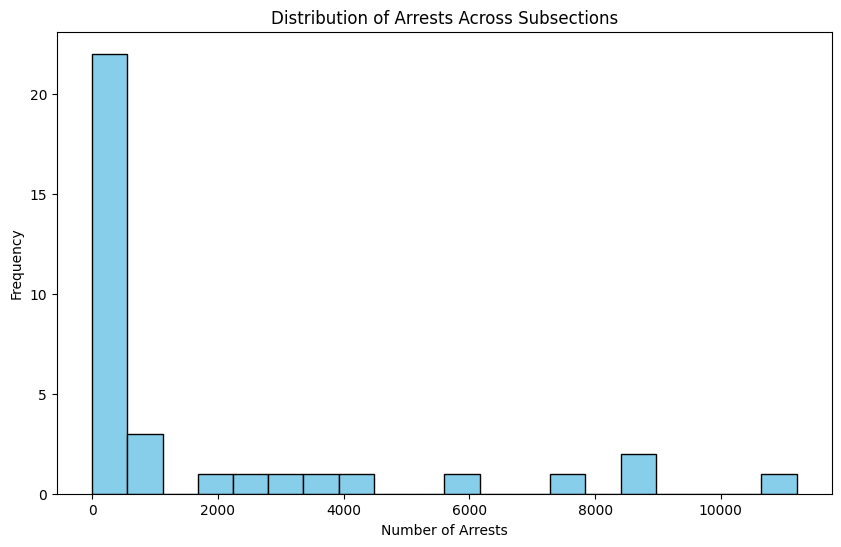

In [368]:
# Create plot to visualize the distribution of arrests across subsections
plt.figure(figsize=(10, 6))
plt.hist(df["arrests"], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Number of Arrests")
plt.ylabel("Frequency")
plt.title("Distribution of Arrests Across Subsections")
plt.show()

#### 3—Visualize Distributions of Features across Given Subsections

Visualize the distribution of infrastructure density to determine if...

- it's a useful feature
- it should be a continuous or categorical variable
- distance to nearest instance is a better metric
- there are outliers

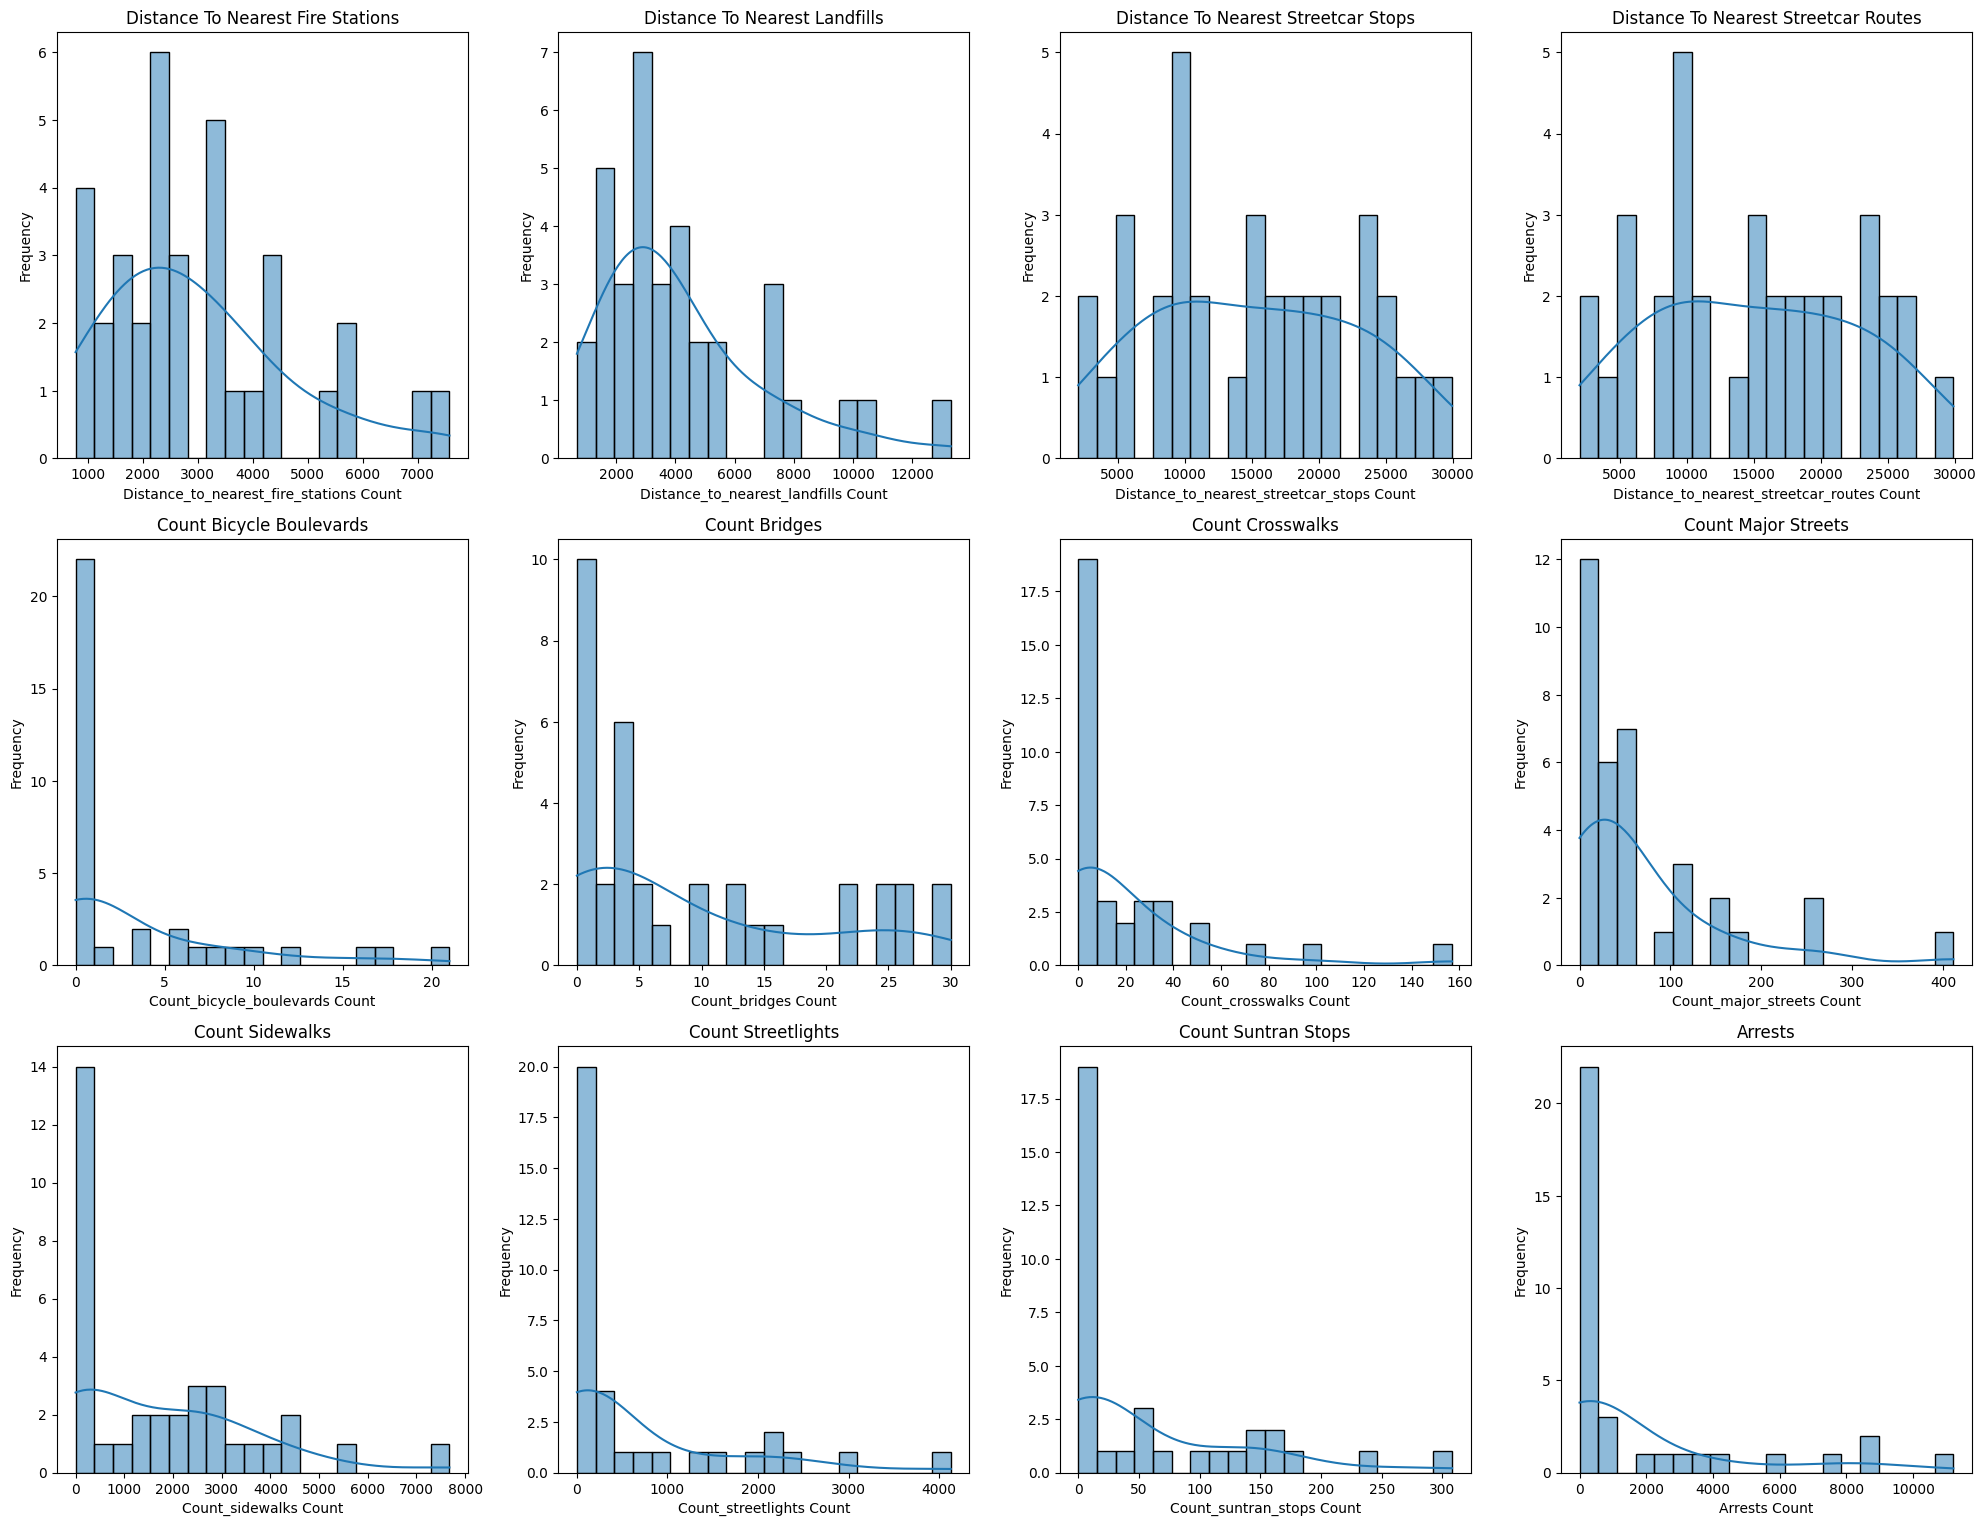

In [369]:
import seaborn as sns


def visualize_feature_dists(dataframe: pd.DataFrame):
    """Create a single plot with subplots for each feature in the input DataFrame.
    Show the distribution of each feature in order to determine if transformations, projections, or re-engineering are needed.
    """
    # Create a figure with a subplot for each feature
    fig, axs = plt.subplots(len(dataframe.columns) // 4 + 1, 4, figsize=(20, 20))

    # Iterate over each feature and create a histogram
    for i, feature in enumerate(dataframe.columns):
        sns.histplot(dataframe[feature], kde=True, bins=20, ax=axs[i // 4, i % 4])
        axs[i // 4, i % 4].set_xlabel(f"{feature.capitalize()} Count")

        # Only need to label y if it's the first column
        axs[i // 4, i % 4].set_ylabel("Frequency")
        axs[i // 4, i % 4].set_title(f"{feature.replace('_', ' ').title()}")

    # Hide any unused subplots
    for i in range(len(dataframe.columns), len(axs.flat)):
        axs.flat[i].set_visible(False)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


visualize_feature_dists(df)

#### 3—Visualize the Correlation of Features with Crime Density

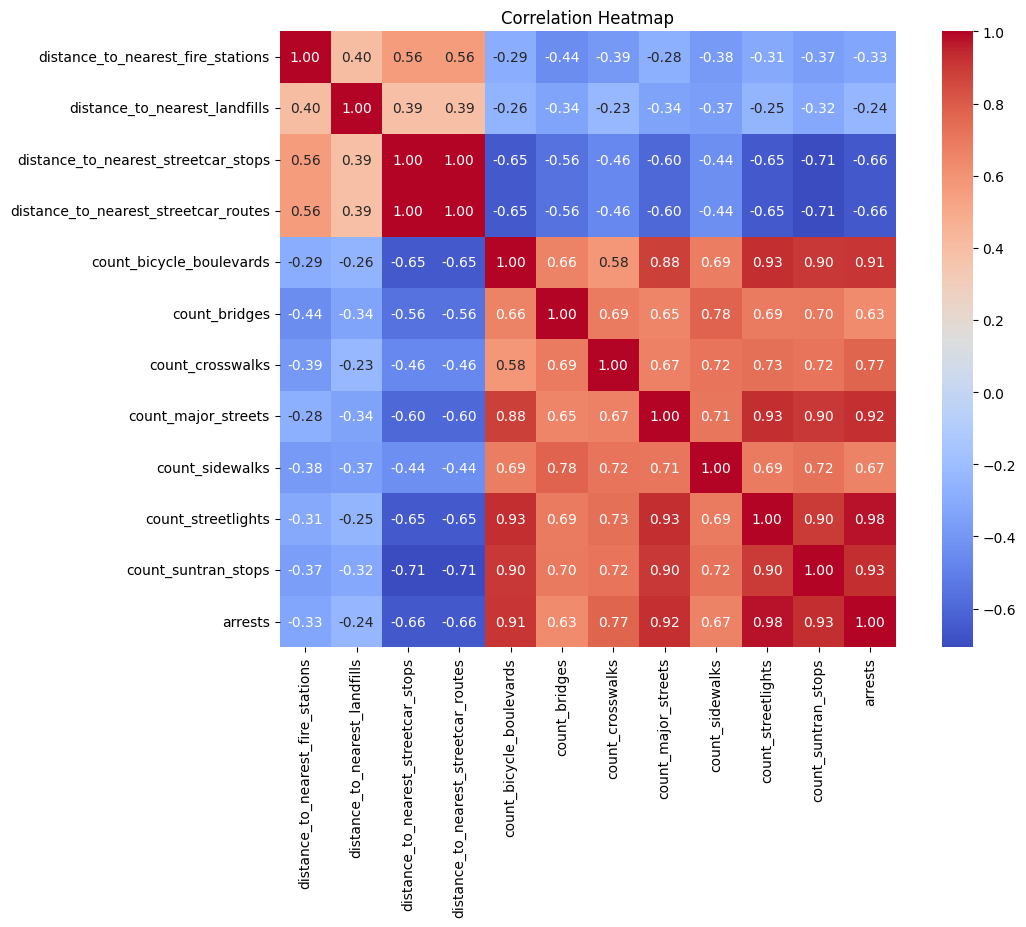

In [370]:
def correlation_heatmap(dataframe: pd.DataFrame):
    """
    Generate a heatmap of correlation coefficients for all numerical features in the DataFrame.
    """
    corr_matrix = dataframe.corr()  # Compute correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True
    )
    plt.title("Correlation Heatmap")
    plt.show()

correlation_heatmap(df)

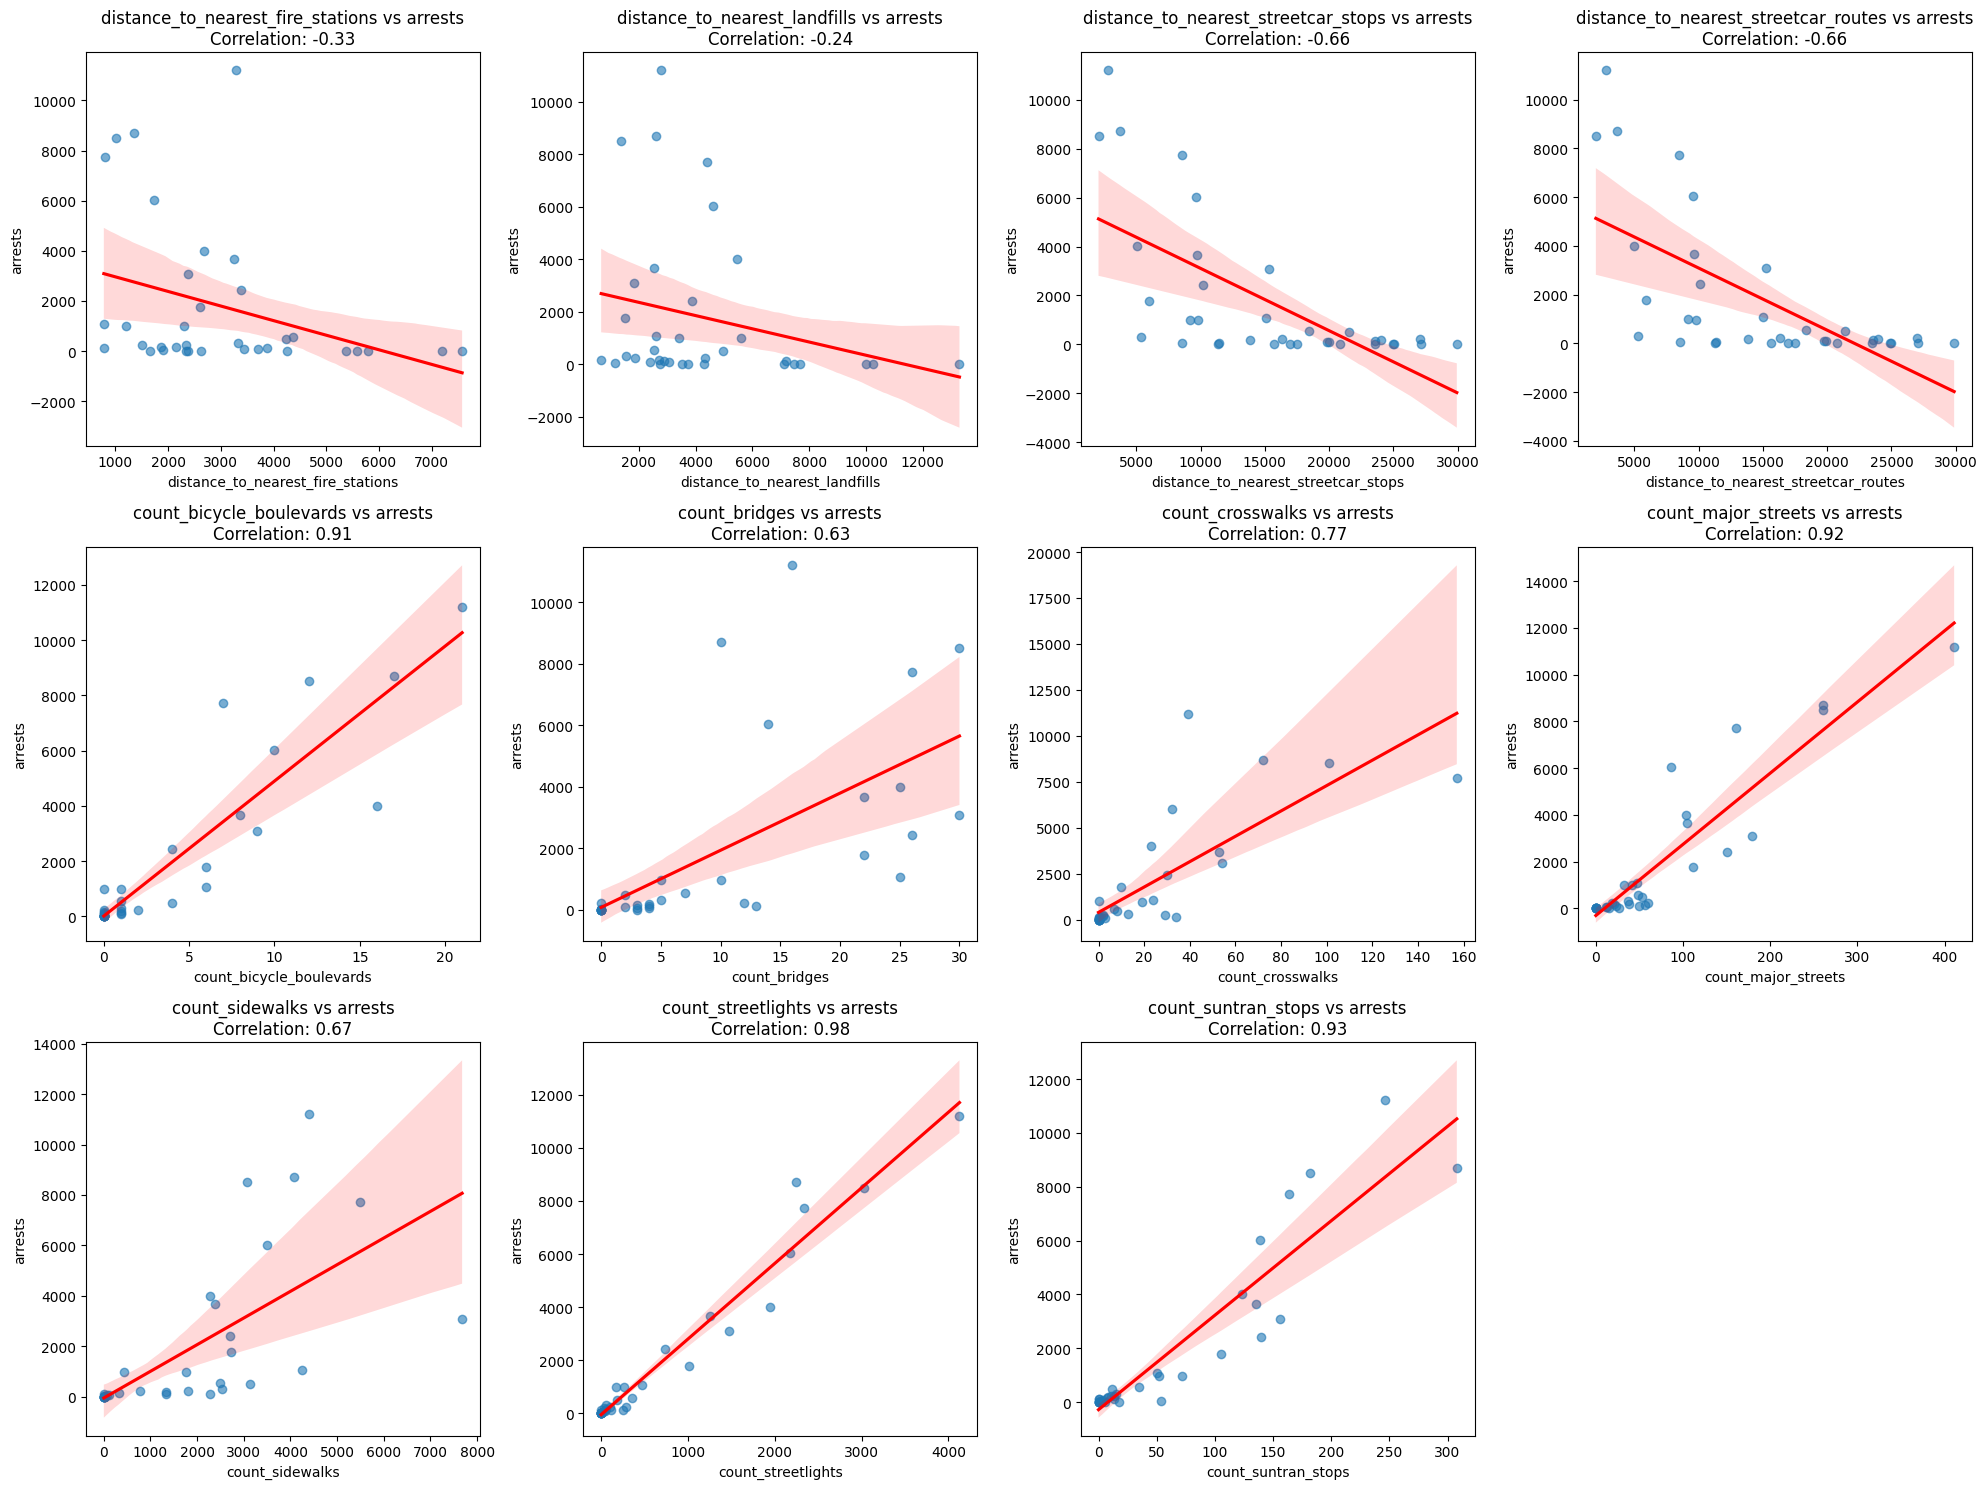

In [371]:
def visualize_feature_correlations(dataframe: pd.DataFrame, target_feature: str):
    """
    Create subplots for each feature in the DataFrame, showing the relationship
    between each feature and the target variable, and print correlation coefficients.
    """
    features = [col for col in dataframe.columns if col != target_feature]
    num_features = len(features)
    num_cols = 4
    num_rows = (num_features + num_cols - 1) // num_cols  # Compute rows dynamically

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

    # Flatten axes for easier indexing
    axs = axs.flatten()

    # Iterate over features and plot
    for i, feature in enumerate(features):
        ax = axs[i]

        # Compute correlation coefficient
        corr_coef = (
            dataframe[feature].corr(dataframe[target_feature])
            if pd.api.types.is_numeric_dtype(dataframe[feature])
            else None
        )

        # Numerical feature
        if pd.api.types.is_numeric_dtype(dataframe[feature]):
            sns.regplot(
                x=dataframe[feature],
                y=dataframe[target_feature],
                ax=ax,
                scatter_kws={"alpha": 0.6},
                line_kws={"color": "red"},
            )
            ax.set_title(f"{feature} vs {target_feature}\nCorrelation: {corr_coef:.2f}")
        # Categorical feature
        else:
            sns.boxplot(x=dataframe[feature], y=dataframe[target_feature], ax=ax)
            ax.set_title(f"{feature} vs {target_feature}")

        ax.set_xlabel(feature)
        ax.set_ylabel(target_feature)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()


visualize_feature_correlations(df, "arrests")

## 5—Model Training

### 5.1—Split Data into Training and Testing Sets

In [372]:
# Create train/test split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = train_test_split(
    df, test_size=config["hp"]["test_size"], random_state=42
)

### 5.2—Normalize Data

Scale (normalize) the data

In [391]:
from sklearn.preprocessing import StandardScaler

# Ensure that the target variable is indeed the last column
assert df.columns[-1] == "arrests"

X_features = df.columns[:-1]  # All columns except the last one
features = df.columns

# Initialize the StandardScaler
scaler = StandardScaler().fit(train[features])  # Scale feature columns

# Scaling is done after train/test split to avoid data leakage
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

Scaled training data

In [389]:
print("Training data after scaling:")
train.head()

Training data after scaling:


,distance_to_nearest_fire_stations,distance_to_nearest_landfills,distance_to_nearest_streetcar_stops,distance_to_nearest_streetcar_routes,count_bicycle_boulevards,count_bridges,count_crosswalks,count_major_streets,count_sidewalks,count_streetlights,count_suntran_stops,arrests
12,-0.516549,-1.272737,1.146980,1.146803,-0.417626,-0.416383,-0.532745,-0.295795,-0.189984,-0.556356,-0.591879,-0.504056
8,-1.297611,-0.016347,-0.947657,-0.942064,0.614156,1.873722,4.244349,1.044623,1.889972,1.699202,1.334594,2.013045
16,-0.205358,0.342880,-1.419828,-1.419203,2.161829,1.769627,0.114474,0.412556,0.283640,1.317553,0.828277,0.773841
9,0.194590,-0.193588,-0.718918,-0.719866,0.098265,1.873722,0.330214,0.924749,0.494527,0.129436,1.038213,0.244136
33,1.589331,1.879401,0.724112,0.720488,-0.589590,-0.832766,-0.594385,-0.709908,-0.852558,-0.592657,-0.690672,-0.563765


Scaled testing data

In [390]:
print("Testing data after scaling:")
test.head()

Testing data after scaling:


,distance_to_nearest_fire_stations,distance_to_nearest_landfills,distance_to_nearest_streetcar_stops,distance_to_nearest_streetcar_routes,count_bicycle_boulevards,count_bridges,count_crosswalks,count_major_streets,count_sidewalks,count_streetlights,count_suntran_stops,arrests
26,-1.310986,0.926251,0.585027,0.580177,-0.417626,0.520478,-0.563565,-0.459261,-0.187989,-0.483754,-0.690672,-0.524404
13,1.473825,-0.568157,1.572020,1.572047,-0.589590,-0.832766,-0.594385,-0.709908,-0.852558,-0.592657,-0.690672,-0.563765
24,0.121918,-0.640583,-0.782454,-0.789028,0.786120,1.457340,1.039073,0.434352,0.338481,0.640591,0.976467,0.658427
21,-0.254595,-0.993329,-1.291864,-1.290271,0.442192,1.457340,-0.286185,0.510636,0.508985,0.397277,0.605992,0.026650
15,-1.176699,-1.033785,-1.821610,-1.821524,1.473975,2.290105,2.518431,2.123497,0.673507,2.379108,1.556879,2.274228


### 5.3—Split Data into Input ($X$) and Output ($y$) Data

In [374]:
# Split into X and y
target_feature_name = "arrests"
other = [col for col in train.columns if col != target_feature_name]

X_train, y_train = train[other], train[target_feature_name]
X_test, y_test = test[other], test[target_feature_name]

### 5.4—Hyperparameter Tuning and Model Selection

#### Best Subsets

In [375]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


best_subsets_lr = LinearRegression()
subset_sizes = []
r2_means_subsets = []
# for subset_size in range(1, len(X_features) + 1):
for subset_size in range(1, 3):
    # Find all possible subsets of features for the current size
    subsets = set(combinations(X_features, subset_size))

    # Calculate the mean R^2 score for each subset
    for subset in subsets:
        mean_r2 = cross_val_score(
            best_subsets_lr,
            X_train[list(subset)],
            y_train,
            cv=config["hp"]["cross_val_folds"]["best_subset"],
            scoring=config["hp"]["scoring_metric"]["best_subset"],
        ).mean()
        subset_sizes.append(subset_size)
        r2_means_subsets.append((mean_r2, subset))

Visualize the general performance of each subset size

Text(0.5, 1.0, 'R² vs. Subset Size')

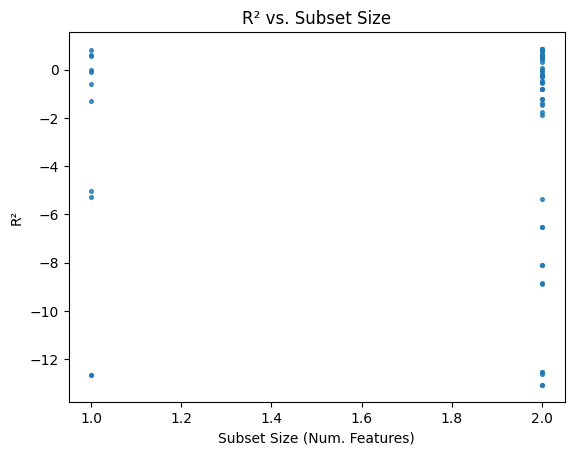

In [376]:
plt.scatter(subset_sizes, [r2 for r2, _ in r2_means_subsets], alpha=0.8, s=7)
plt.xlabel("Subset Size (Num. Features)")
plt.ylabel("R²")
plt.title("R² vs. Subset Size")

Determine the best-performing subset size

In [377]:
best_r2_subset_2, best_feature_combo = sorted(r2_means_subsets, key=lambda x: -x[0])[0]
print(
    f"Best-performing set of features:\n\t{best_feature_combo}\n\tR² = {best_r2_subset_2}"
)

Best-performing set of features:
	('distance_to_nearest_streetcar_stops', 'count_streetlights')
	R² = 0.8584079865244334


#### Ridge

In [378]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import numpy as np

# Create a range of 50 alpha values spaced logarithmically in the range [10^-1, 10^3]
domain = np.logspace(-1, 3, 50)

# Find the best alpha value across domain
r2_means_ridge, r2_stds_ridge = [], []
for alpha in domain:
    reg = linear_model.Ridge(alpha=alpha)
    r2_vals = cross_val_score(
        reg,
        X_train,
        y_train,
        cv=config["hp"]["cross_val_folds"]["ridge"],
        scoring=config["hp"]["scoring_metric"]["ridge"],
    )
    r2_means_ridge.append(r2_vals.mean())
    r2_stds_ridge.append(r2_vals.std())

Visualize the performance of each alpha value

Text(0, 0.5, 'Average R²')

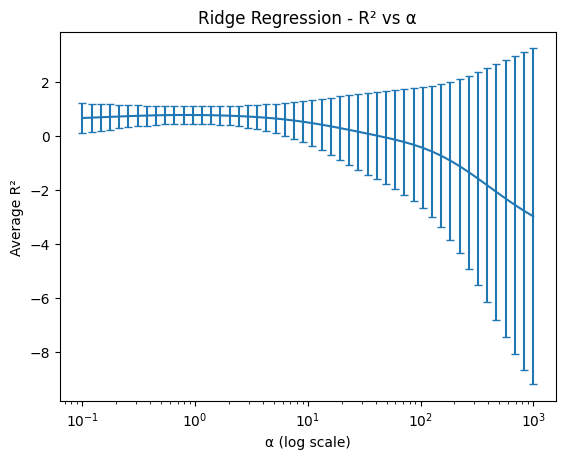

In [379]:
plt.errorbar(domain, r2_means_ridge, yerr=r2_stds_ridge, fmt="-", capsize=3)
plt.xscale("log")
plt.title("Ridge Regression - R² vs α")
plt.xlabel("α (log scale)")
plt.ylabel("Average R²")

Report the best-performing alpha value

In [380]:
best_r2_ridge = np.max(r2_means_ridge)
best_alpha_ridge = domain[np.argmax(r2_means_ridge)]
print(f"Best R²: {best_r2_ridge:.3f}\nBest α: {best_alpha_ridge:.3f}")

Best R²: 0.762
Best α: 0.791


#### Lasso

In [381]:
reg_lasso_lars = linear_model.LassoLarsCV(cv=config["hp"]["cross_val_folds"]["lasso"])
reg_lasso_lars.fit(X_train, y_train)
reg_lasso_lars.coef_

array([-0.0018256 ,  0.00155468,  0.        , -0.02108732,  0.        ,
       -0.13778445,  0.15717641,  0.01216575, -0.04913518,  0.70995292,
        0.28644961])

Visualize the performance of each regularization coefficient

Text(0, 0.5, 'Average MSE for 20-fold CV')

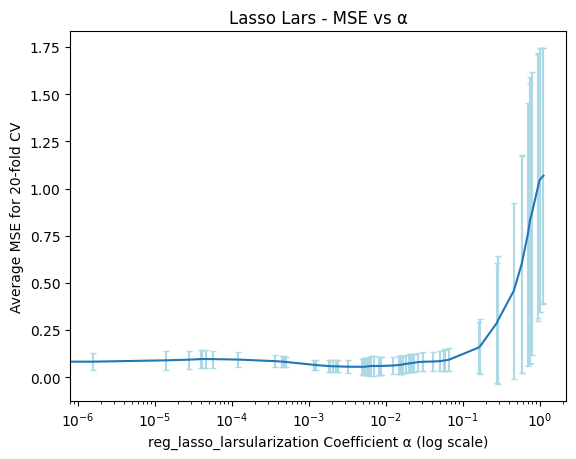

In [382]:
# Plot the MSE for each α value
plt.errorbar(
    reg_lasso_lars.cv_alphas_,  # = α values
    reg_lasso_lars.mse_path_.mean(axis=1),  # = mean of MSE for each α across 20 folds
    yerr=reg_lasso_lars.mse_path_.std(
        axis=1
    ),  # = standard deviation of MSE for each α across 20 folds
    fmt="-",
    capsize=2,
    ecolor="lightblue",
)
plt.xscale("log")
plt.title("Lasso Lars - MSE vs α")
plt.xlabel("reg_lasso_larsularization Coefficient α (log scale)")
plt.ylabel("Average MSE for 20-fold CV")

Report the best-performing regularization coefficient value

In [383]:
# report the best alpha and the corresponding MSE
best_alpha_lasso = reg_lasso_lars.alpha_
best_mse_lasso = reg_lasso_lars.mse_path_.mean(axis=1)[
    np.where(reg_lasso_lars.cv_alphas_ == best_alpha_lasso)
][0]
print(f"Best α: {best_alpha_lasso:.4f}\nMSE: {best_mse_lasso:.4f}")

Best α: 0.0050
MSE: 0.0552


Add a bar to visualize where the best-performing regularization coefficient is on the graph

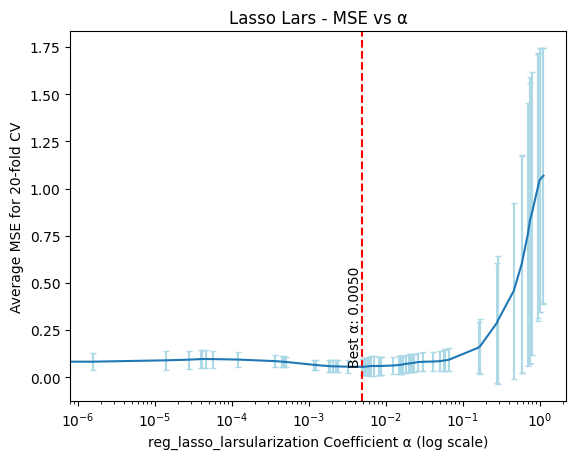

In [384]:
# Plot the MSE for each α value
plt.errorbar(
    reg_lasso_lars.cv_alphas_,  # = α values
    reg_lasso_lars.mse_path_.mean(axis=1),  # = mean of MSE for each α across 20 folds
    yerr=reg_lasso_lars.mse_path_.std(
        axis=1
    ),  # = standard deviation of MSE for each α across 20 folds
    fmt="-",
    capsize=2,
    ecolor="lightblue",
)
plt.xscale("log")
plt.title("Lasso Lars - MSE vs α")
plt.xlabel("reg_lasso_larsularization Coefficient α (log scale)")
plt.ylabel("Average MSE for 20-fold CV")

# Highlight best alpha on plot
plt.axvline(best_alpha_lasso, color="red", linestyle="--")
plt.text(
    best_alpha_lasso,
    best_mse_lasso,
    f"Best α: {best_alpha_lasso:.4f}",
    rotation=90,
    va="bottom",
    ha="right",
);

## 6—Model Evaluation

### 6.1—Evaluate Regression Types on Testing Data

##### Best Subsets

In [385]:
import sklearn.metrics
import statsmodels.api as sm

# use best combination of features from previous step to fit the model
best_subsets_lr = linear_model.LinearRegression()
best_subsets_lr.fit(X_train[list(best_feature_combo)], y_train)

# score the model's accuracy on the test data
r2_best_subsets = best_subsets_lr.score(X_test[list(best_feature_combo)], y_test)
preds_best_subsets = best_subsets_lr.predict(X_test[list(best_feature_combo)])
mse_best_subsets = sklearn.metrics.mean_squared_error(y_test, preds_best_subsets)

print(
    "Best Subsets:",
    f"Features Used: {best_feature_combo}",
    f"Coefficients: {best_subsets_lr.coef_}",
    f"MSE: {mse_best_subsets:.3f}",
    f"R²: {r2_best_subsets:.3f}\n",
    sep="\n\t",
)

# show an additional summary of the model
X_train_sm = sm.add_constant(X_train[list(best_feature_combo)])
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

Best Subsets:
	Features Used: ('distance_to_nearest_streetcar_stops', 'count_streetlights')
	Coefficients: [-0.06303174  0.93802385]
	MSE: 0.029
	R²: 0.968

                            OLS Regression Results                            
Dep. Variable:                arrests   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     270.4
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           1.17e-17
Time:                        13:03:18   Log-Likelihood:                 3.9390
No. Observations:                  28   AIC:                            -1.878
Df Residuals:                      25   BIC:                             2.119
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                          coef    std

##### Ridge

In [386]:
# use best alpha value from previous step to fit the model
reg_ridge = linear_model.Ridge(alpha=best_alpha_ridge)
reg_ridge.fit(X_train, y_train)

# score the model's accuracy on the test data
r2_ridge = reg_ridge.score(X_test, y_test)
preds_ridge = reg_ridge.predict(X_test)
mse_ridge = sklearn.metrics.mean_squared_error(y_test, preds_ridge)

print(
    "Ridge Regression:",
    f"Coefficients:{reg_ridge.coef_}",
    f"alpha = {best_alpha_ridge:.3f}",
    f"MSE = {mse_ridge:.3f}",
    f"R² = {r2_ridge:.3f}",
    sep="\n\t",
)

Ridge Regression:
	Coefficients:[-0.01320692  0.02795872 -0.02049853 -0.02277358  0.12093298 -0.14352502
  0.20665544  0.1290353  -0.05791641  0.51037288  0.21396791]
	alpha = 0.791
	MSE = 0.009
	R² = 0.990


##### Lasso

In [387]:
# use the optimal regularization coefficient from the previous step to fit the model
reg_lasso = linear_model.Lasso(alpha=best_alpha_lasso)
reg_lasso.fit(X_train, y_train)

# score the model's accuracy on the test data
r2_lasso = reg_lasso.score(X_test, y_test)
preds_lasso = reg_lasso.predict(X_test)
mse_lasso = sklearn.metrics.mean_squared_error(preds_lasso, y_test)

print(
    "Lasso Regression:",
    f"Coefficients:{reg_lasso.coef_}",
    f"alpha = {reg_lasso.alpha}",
    f"MSE = {mse_lasso:.3f}",
    f"R² = {r2_lasso:.3f}",
    sep="\n\t",
)

Lasso Regression:
	Coefficients:[-0.00176449  0.00150956 -0.01213886 -0.00894296  0.         -0.13747671
  0.15735531  0.01236436 -0.04957392  0.70946636  0.28673037]
	alpha = 0.00495281602128079
	MSE = 0.011
	R² = 0.987


### 5.4.5—Compare Feature Weights for each Model

In [388]:
feature_names = df.columns[:-1]

model_names = ["Best Subset Regression", "Ridge Regression", "Lasso Regression"]
results_df = pd.DataFrame(columns=model_names, index=feature_names)

for i, feature in enumerate(feature_names):
    results_df.loc[feature] = [
        (
            best_subsets_lr.coef_[list(best_feature_combo).index(feature)]
            if feature in best_feature_combo
            else 0
        ),
        reg_ridge.coef_[i],
        reg_lasso.coef_[i],
    ]

# create another table comparing metrics
metrics_df = pd.DataFrame(columns=model_names, index=["MSE", "R²"])
metrics_df.loc["MSE"] = [mse_best_subsets, mse_ridge, mse_lasso]
metrics_df.loc["R²"] = [r2_best_subsets, r2_ridge, r2_lasso]
print("Model performance metrics:\n")
print(metrics_df)

print("\n\nModel Feature weights:")
results_df

Model performance metrics:

    Best Subset Regression Ridge Regression Lasso Regression
MSE               0.028509         0.009158         0.011327
R²                0.967791         0.989654         0.987203


Model Feature weights:


,Best Subset Regression,Ridge Regression,Lasso Regression
distance_to_nearest_fire_stations,0,-0.013207,-0.001764
distance_to_nearest_landfills,0,0.027959,0.00151
distance_to_nearest_streetcar_stops,-0.063032,-0.020499,-0.012139
distance_to_nearest_streetcar_routes,0,-0.022774,-0.008943
count_bicycle_boulevards,0,0.120933,0.0
count_bridges,0,-0.143525,-0.137477
count_crosswalks,0,0.206655,0.157355
count_major_streets,0,0.129035,0.012364
count_sidewalks,0,-0.057916,-0.049574
count_streetlights,0.938024,0.510373,0.709466


## 7—Discussion and Visualization